In [1]:
import sys  ###occlusion_free_mcl
sys.path.append('../scripts/')
from mcl import *

In [2]:
class OcclusionFreeParticle(Particle): 
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            ##パーティクルの位置と地図からランドマークの距離と方角を算出##
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            ##尤度の計算##
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2])) #ここまでParticleクラスと同じ実装
            if obs_pos[0] > particle_suggest_pos[0]:  #観測された距離がパーティクルから計算される距離より大きい場合、
                obs_pos[0] = particle_suggest_pos[0]  #パーティクルから計算される距離で観測された距離を置き換える
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)

<IPython.core.display.Javascript object>


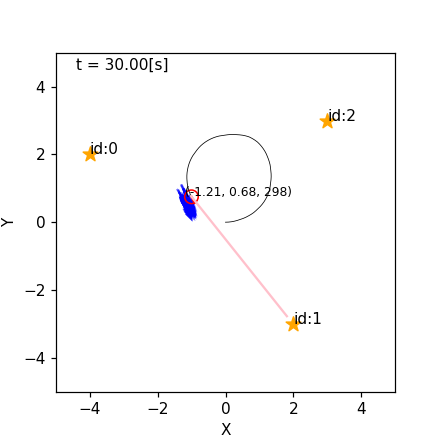

In [3]:
def trial(animation): 
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)

    ## ロボットを作る ##
    initial_pose = np.array([0, 0, 0]).T
    pf = Mcl(m, initial_pose, 100)
    pf.particles = [OcclusionFreeParticle(initial_pose, 1.0/100) for i in range(100)] #OcclusionFreeParticleをMclに使わせる
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(initial_pose, sensor=Camera(m, occlusion_prob=0.5), agent=circling, color="red")
    world.append(r)
    world.draw()
    
trial(True)